In [ ]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
import matplotlib.pyplot as plt
import scipy

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, bin_data_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename
from backends import plot, density_model

print("Importing tensorflow and keras")
import tensorflow    as tf
from   keras.layers  import Input, Concatenate, Lambda
from   keras.models  import Model
import keras.backend as     K



In [ ]:
#  Inputs config

load_model_EWK        = ".EWK_density_model"
load_model_QCD        = ".QCD_density_model_2M"
xsection_models_fname = ".xsection_models.pickle"
load_whitening_funcs  = ".whitening_funcs.pickle"

L               = 140e3         # integrated luminosity in /pb
n_gen_EWK       = int(1e5)      # number of events to importance sample
n_gen_QCD       = int(1e6)      # number of events to importance sample

target_cWtil = 0.1

In [3]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = ["N_jets", "pT_ll", "rap_ll", "theta_ll", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "N_gap_jets"]

int_observables = ["N_jets", "N_gap_jets"]

observables_order  = ["m_jj", "m_ll", "Dphi_j_j", "Dy_j_j"]
observables_types  = [int if obs in int_observables else float for obs in observables_order]
observables_labels = {"m_jj":r"$m_{\rm jj}$", "m_ll":r"$m_{\rm ll}$", "Dphi_j_j":r"$\Delta\phi(j,j)$", "Dy_j_j":r"$\Delta y(j,j)$"}

plot.observable_limits = observable_limits
plot.int_observables   = int_observables

num_observables = len(observables_order)


In [44]:
#  Load functions for whitening/unwhitening the data
#

print(f"Loading whitening functions from file {load_whitening_funcs}")
whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))

Loading whitening functions from file .whitening_funcs.pickle


In [4]:
#  Load EWK and QCD cross sections
#

xsection_models = pickle.load(open(xsection_models_fname, "rb"))

sigma_QCD     = xsection_models ["QCD_cross_section"]
sigma_QCD_err = xsection_models ["QCD_cross_section_err"]
sigma_EWK     = xsection_models ["EWK_paramA"]
sigma_tot     = sigma_EWK + sigma_QCD

print(f"sigma_EWK = {sigma_EWK:.3f}")
print(f"sigma_QCD = {sigma_QCD:.3f} +/- {sigma_QCD_err:.3f}")
print(f"sigma_tot = {sigma_tot:.3f}")


sigma_EWK = 0.290
sigma_QCD = 13.828 +/- 0.013
sigma_tot = 14.118


In [5]:
#  Load EWK and QCD density models
#

density_model_EWK = DensityModel.from_dir(load_model_EWK)
for m in density_model_EWK.likelihood_models :
    m.model.summary()

density_model_QCD = DensityModel.from_dir(load_model_QCD)
for m in density_model_QCD.likelihood_models :
    m.model.summary()


INFO       DensityModel.construct      Set model name           : dflt
INFO       DensityModel.construct      Set model num_gaussians  : 2
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 1
INFO       DensityModel.construct      Set observable types     : [<class 'float'>]
INFO       DensityModel.construct      Set kernel_initializer   : glorot_uniform
INFO       DensityModel.construct      Set bias_initializer     : zeros
Model: "EWK_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 7)            

Model: "QCD_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 7)            14          input_10[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_27 (LeakyReLU)      (None, 7)            0           dense_45[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 40)           320         leaky_re_lu_27[0][0]             
______________________________________________________________________

In [6]:
#  Figure out how many Gaussians are used for each model
#  -  assumed that all layers have the same number
#

EWK_gauss_params_dummy = density_model_EWK.likelihood_models[0].get_gauss_params([0])
num_gauss_EWK          = int(EWK_gauss_params_dummy.shape[1] / 3)
print(f"EWK model with {num_gauss_EWK} Gaussians per layer")

QCD_gauss_params_dummy = density_model_QCD.likelihood_models[0].get_gauss_params([0])
num_gauss_QCD          = int(QCD_gauss_params_dummy.shape[1] / 3)
print(f"QCD model with {num_gauss_QCD} Gaussians per layer")



W1014 16:08:19.064198 4396197312 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


EWK model with 20 Gaussians per layer
QCD model with 20 Gaussians per layer


In [7]:
#  Create logL models using tf and keras for speed
#

sqrt_2pi = np.sqrt(2*np.pi)

#  Keras implementation of Gaussian PDF
#
def K_gauss_prob (x, mean, sigma) :
    return K.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / K.sqrt(2*np.pi*sigma*sigma)


#  Keras calculation of likelihood per-datapoint
#
def K_datapoint_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    prob = 0.
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[:,i] * K_gauss_prob(x, gauss_means[:,i], gauss_sigmas[:,i])
    return prob


#  Keras calculation of log-likelihood per-datapoint
#
def K_datapoint_log_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    return K.log(K_datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))


#  Keras calculation of log-likelihood for set of datapoints
#
def K_dataset_log_likelihood (x, params, num_gauss) :
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K_datapoint_log_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas)


#  Keras calculation of EWK log-likelihood for set of datapoints
#
def K_get_log_likelihood_EWK (inputs) :
    eval_p, params_p = inputs[0], inputs[1]
    return K_dataset_log_likelihood (eval_p, params_p, num_gauss_EWK)


#  Keras calculation of EWK log-likelihood for set of datapoints
#
def K_get_log_likelihood_QCD (inputs) :
    eval_p, params_p = inputs[0], inputs[1]
    return K_dataset_log_likelihood (eval_p, params_p, num_gauss_QCD)


#  Keras layer to combine EWK and QCD logL values for set of datapoints
#
def combine_EWK_QCD_log_likelihoods (inputs) :
    logL_EWK, logL_QCD = inputs[0], inputs[1]
    return K.log((sigma_EWK*K.exp(logL_EWK) + sigma_QCD*K.exp(logL_QCD)) / sigma_tot)


In [8]:
#  Get lists of Keras EWK and QCD density models
#
EWK_models = [x.model for x in density_model_EWK.likelihood_models]
QCD_models = [x.model for x in density_model_QCD.likelihood_models]


#  Define input layers for evaluator models
#
condition_input_layer_cWtil = Input((1,), name="cWtil_input")
condition_input_layer_QCD   = Input((1,), name="QCD_input")
obs_input_layer             = Input((num_observables,), name="observable_input")


#  Split inputs and pipe them through individual layers of the EWK and QCD density models
#  -  each one models a separate conditional probability, to be combined afterwards
#
EWK_logL_layers, QCD_logL_layers = [], []
for i, (EWK_model, QCD_model) in enumerate(zip(EWK_models, QCD_models)) :
    model_inputs_EWK = [condition_input_layer_cWtil]
    model_inputs_QCD = [condition_input_layer_QCD  ]
    if i > 0 :
        cond_obs_split_layer = Lambda(lambda x : x[:, :i], name=f"split_observable_below{i}")(obs_input_layer)
        model_inputs_EWK.append(cond_obs_split_layer)
        model_inputs_QCD.append(cond_obs_split_layer)
    EWK_params = EWK_model(model_inputs_EWK)
    QCD_params = QCD_model(model_inputs_QCD)
    eval_p     = Lambda(lambda x : x[:, i], name=f"split_observable_eq{i}")(obs_input_layer)
    EWK_logL_layers.append(Lambda(K_get_log_likelihood_EWK, name=f"EWK_logL_observable{i}")([eval_p, EWK_params]))
    QCD_logL_layers.append(Lambda(K_get_log_likelihood_QCD, name=f"QCD_logL_observable{i}")([eval_p, QCD_params]))

#  Keras Lambda layers to perform conditional probability combination
#
EWK_logL = Lambda(lambda x : tf.add_n(x), name="EWK_logL_total")(EWK_logL_layers)
QCD_logL = Lambda(lambda x : tf.add_n(x), name="QCD_logL_total")(QCD_logL_layers)



#  Build individual logL models combining EWK and QCD layers separately
#
QCD_logL_model = Model([condition_input_layer_QCD, obs_input_layer], QCD_logL)
QCD_logL_model.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 

EWK_logL_model = Model([condition_input_layer_cWtil, obs_input_layer], EWK_logL)
EWK_logL_model.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 


# Build EvaluatorModel
#
QCD_precomputed_logL = Input((1,), name="QCD_logL_input")
QCD_precomputed_logL_reshaped = Lambda(lambda x : x[:,0], name="QCD_logL_input_reshaped")(QCD_precomputed_logL)
dataset_logL   = Lambda(combine_EWK_QCD_log_likelihoods, name="combined_logL_full")([EWK_logL, QCD_precomputed_logL_reshaped])
EvaluatorModel = Model(inputs  = [condition_input_layer_cWtil, QCD_precomputed_logL, obs_input_layer],
                       outputs = dataset_logL)
EvaluatorModel.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 


# Build FullEvaluatorModel
#
dataset_logL_alt   = Lambda(combine_EWK_QCD_log_likelihoods, name="combined_logL_partial")([EWK_logL, QCD_logL])
FullEvaluatorModel = Model(inputs  = [condition_input_layer_cWtil, condition_input_layer_QCD, obs_input_layer],
                           outputs = dataset_logL_alt)
FullEvaluatorModel.compile(loss=lambda y_true, y_pred : y_pred, optimizer="adam") 



In [126]:
#  When density models are sampled, these global variables will be updated
#
fake_datapoint_weights, fake_white_datapoints, sum_weights, QCD_logL, QCD_L, EWK_logL, EWK_L, dummy_zeros = None, None, None, None, None, None, None, None


#  Define function which samples density models
#
def sample_density_models (n_gen_EWK, n_gen_QCD, weight_fraction_EWK=-1) :
    global fake_datapoint_weights, fake_white_datapoints, sum_weights, QCD_logL, QCD_L, EWK_logL, EWK_L, dummy_zeros
    n_gen = n_gen_EWK + n_gen_QCD
    assert n_gen > 0

    #  1. Generate a large number of EWK and QCD datapoints at 0.
    #
    #  2. Compute logL_QCD (to avoid performing the same calc every time we eval logL_tot)
    #
    #  3. Compute logL_EWK (to help with datapoint reweighting)
    #
    #  4. Weight events to represent total likelihood
    #       N.B. if EWK and QCD events have disjoint supports, there will be some bias in the Asimov here
    #          but as long as all signal models are identical in the biased region, the bias drops out
    #
    
    #  Sanity checks
    #
    if n_gen_EWK < 0 : raise RuntimeError(f"n_gen_EWK = {n_gen_EWK} cannot be negative")
    if n_gen_QCD < 0 : raise RuntimeError(f"n_gen_QCD = {n_gen_QCD} cannot be negative")
    if n_gen == 0    : raise RuntimeError("Must generate nonzero number of events")

    #  Generate EWK events
    #
    if n_gen_EWK > 0 : 
        print(f"Generating {n_gen_EWK} fake EWK datapoints")
        start = time.time()
        fake_white_datapoints_from_EWK = density_model_EWK.sample(n_gen_EWK, [0])
        print(f"{n_gen_EWK} EWK datapoints generated at cWtil=0 in {int(time.time()-start):.0f}s")
        
        print("Computing QCD logL for generated datapoints")
        dummy_zeros_from_EWK = np.zeros(n_gen_EWK)
        start = time.time()
        QCD_logL_from_EWK = QCD_logL_model.predict([dummy_zeros_from_EWK, fake_white_datapoints_from_EWK], verbose=0)
        QCD_L_from_EWK    = np.exp(QCD_logL_from_EWK)
        print(f"QCD logL computed in {time.time()-start:.2f}s")
        
        print("Computing EWK logL for generated datapoints")
        start = time.time()
        EWK_logL_from_EWK = EWK_logL_model.predict([dummy_zeros_from_EWK, fake_white_datapoints_from_EWK], verbose=0)
        EWK_L_from_EWK    = np.exp(EWK_logL_from_EWK)
        print(f"EWK logL computed in {time.time()-start:.2f}s")
    else :
        fake_white_datapoints_from_EWK = np.zeros(shape=(0, num_observables))
        QCD_logL_from_EWK = np.zeros(shape=(0,))
        QCD_L_from_EWK    = np.zeros(shape=(0,))
        EWK_logL_from_EWK = np.zeros(shape=(0,))
        EWK_L_from_EWK    = np.zeros(shape=(0,))
    
    #  Generate QCD events
    #
    if n_gen_QCD > 0 : 
        print(f"Generating {n_gen_QCD} fake QCD datapoints")
        start = time.time()
        fake_white_datapoints_from_QCD = density_model_QCD.sample(n_gen_QCD, [0])
        print(f"{n_gen_QCD} QCD datapoints generated in {int(time.time()-start):.0f}s")
        
        print("Computing QCD logL for generated datapoints")
        dummy_zeros_from_QCD = np.zeros(n_gen_QCD)
        start = time.time()
        QCD_logL_from_QCD = QCD_logL_model.predict([dummy_zeros_from_QCD, fake_white_datapoints_from_QCD], verbose=0)
        QCD_L_from_QCD    = np.exp(QCD_logL_from_QCD)
        print(f"QCD logL computed in {time.time()-start:.2f}s")
        
        print("Computing EWK logL for generated datapoints")
        start = time.time()
        EWK_logL_from_QCD = EWK_logL_model.predict([dummy_zeros_from_QCD, fake_white_datapoints_from_QCD], verbose=0)
        EWK_L_from_QCD    = np.exp(EWK_logL_from_QCD)
        print(f"EWK logL computed in {time.time()-start:.2f}s")
    else :
        fake_white_datapoints_from_QCD = np.zeros(shape=(0, num_observables))
        QCD_logL_from_QCD = np.zeros(shape=(0,))
        QCD_L_from_QCD    = np.zeros(shape=(0,))
        EWK_logL_from_QCD = np.zeros(shape=(0,))
        EWK_L_from_QCD    = np.zeros(shape=(0,))

    #  Get event weights
    #
    sigma_gen_EWK, sigma_gen_QCD = n_gen_EWK / L, n_gen_QCD / L
    print("Calculating event weights")        
    if (n_gen_EWK > 0) and (n_gen_QCD > 0) and weight_fraction_EWK < 0 :
        print("Not importance sampling (event weights are n_exp/n_gen - be careful when this factor is very different for EWK and QCD events, as one will dominate the stat fluctuations!)")
        fake_datapoint_weights_EWK = np.full(shape=(n_gen_EWK,), fill_value=sigma_EWK/sigma_gen_EWK)
        fake_datapoint_weights_QCD = np.full(shape=(n_gen_QCD,), fill_value=sigma_QCD/sigma_gen_QCD)
        fake_datapoint_weights     = np.concatenate([fake_datapoint_weights_EWK, fake_datapoint_weights_QCD])
    else :
        print(f"Importance sampling with EWK fraction {weight_fraction_EWK}")
        weight_fraction_EWK_actual = n_gen_EWK / n_gen
        if sigma_gen_EWK == 0 :
            weight_fraction_EWK_actual = 0
            print(f"- no EWK events generated, so setting EWK fraction to {weight_fraction_EWK_actual}")
            fake_datapoint_weights_EWK = np.zeros(shape=(0,))
        else :
            fake_datapoint_weights_EWK = np.full(fill_value=1./n_gen, shape=(n_gen_EWK,))
        if sigma_gen_QCD == 0 :
            weight_fraction_EWK_actual = 1
            print(f"- no QCD events generated, so setting EWK fraction to {weight_fraction_EWK_actual}")
            fake_datapoint_weights_QCD = np.zeros(shape=(0,))
        else :
            fake_datapoint_weights_QCD = np.full(fill_value=1./n_gen, shape=(n_gen_QCD,))
        fake_datapoint_weights = np.concatenate([fake_datapoint_weights_EWK, fake_datapoint_weights_QCD])
        QCD_logL = np.concatenate([QCD_logL_from_EWK, QCD_logL_from_QCD])
        QCD_L    = np.concatenate([QCD_L_from_EWK   , QCD_L_from_QCD   ])
        EWK_logL = np.concatenate([EWK_logL_from_EWK, EWK_logL_from_QCD])
        EWK_L    = np.concatenate([EWK_L_from_EWK   , EWK_L_from_QCD   ])
        gen_L    = weight_fraction_EWK_actual*EWK_L + (1-weight_fraction_EWK_actual)*QCD_L
        target_L = (sigma_EWK*EWK_L + sigma_QCD*QCD_L) / sigma_tot
        fake_datapoint_weights = fake_datapoint_weights * (target_L * sigma_tot * L) / gen_L
    
    '''else :
        print(f"Importance sampling with EWK fraction {weight_fraction_EWK}")
        weight_fraction_EWK_actual = weight_fraction_EWK
        if sigma_gen_EWK > 0 :
            fake_datapoint_weights_EWK = (1. / sigma_gen_EWK) * (sigma_EWK + (sigma_QCD*QCD_L_from_EWK/EWK_L_from_EWK))
        else :
            fake_datapoint_weights_EWK = np.array([])
            weight_fraction_EWK_actual = 0
            print(f"- no EWK events generated, so setting EWK fraction to {weight_fraction_EWK_actual}")
        if sigma_gen_QCD > 0 :
            fake_datapoint_weights_QCD = (1. / sigma_gen_QCD) * (sigma_QCD + (sigma_EWK*EWK_L_from_QCD/QCD_L_from_QCD))
        else :
            fake_datapoint_weights_QCD = np.array([])
            weight_fraction_EWK_actual = 1
            print(f"- no QCD events generated, so setting EWK fraction to {weight_fraction_EWK_actual}")
        fake_datapoint_weights_EWK = fake_datapoint_weights_EWK * weight_fraction_EWK_actual
        fake_datapoint_weights_QCD = fake_datapoint_weights_QCD * (1. - weight_fraction_EWK_actual) 
    fake_datapoint_weights = np.concatenate([fake_datapoint_weights_EWK, fake_datapoint_weights_QCD])'''

    #  Combine events sampled from EWK and QCD densities to create single asimov dataset

    fake_white_datapoints  = np.concatenate([fake_white_datapoints_from_EWK , fake_white_datapoints_from_QCD ])
    sum_weights            = np.sum(fake_datapoint_weights)
    sum_weights_err        = np.sum(fake_datapoint_weights*fake_datapoint_weights)
    QCD_logL               = np.concatenate([QCD_logL_from_EWK, QCD_logL_from_QCD])
    QCD_L                  = np.concatenate([QCD_L_from_EWK, QCD_L_from_QCD])
    EWK_logL               = np.concatenate([EWK_logL_from_EWK, EWK_logL_from_QCD])
    EWK_L                  = np.concatenate([EWK_L_from_EWK, EWK_L_from_QCD])
    dummy_zeros            = np.zeros(n_gen)
    sum_weights_err        = np.sqrt(sum_weights_err)

    #  Print summary

    print(f"sigma_gen_EWK = {sigma_gen_EWK:.3f}")
    print(f"sigma_gen_QCD = {sigma_gen_QCD:.3f}")
    print(f"sigma_EWK     = {sigma_EWK:.3f}")
    print(f"sigma_QCD     = {sigma_QCD:.3f}")
    print(f"sigma_tot     = {sigma_tot:.3f}")
    print(f"sigma_asimov  = {sum_weights/L:.3f} +/- {sum_weights_err/L:.3f}")
    print(f"N_exp         = {sigma_tot*L:.3f}")
    print(f"N_asimov      = {sum_weights:.3f} +/- {sum_weights_err:.3f}")


In [134]:
#  Create a dataset to study
#
sample_density_models(n_gen_EWK, n_gen_QCD, gen_weight_EWK) 


Generating 100000 fake EWK datapoints
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
100000 EWK datapoints generated at cWtil=0 in 59s
Computing QCD logL for generated datapoints
QCD logL computed in 4.01s
Computing EWK logL for generated datapoints
EWK logL computed in 3.64s
Generating 1000000 fake QCD datapoints
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 1000000 datapoints, observable index is 3
1000000 QCD dat

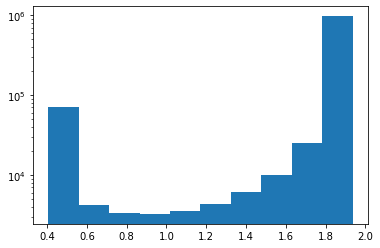

In [135]:
plt.hist(fake_datapoint_weights)
plt.gca().set_yscale("log")
plt.show()

In [137]:
#  Compute logL at SM for generated datapoints
#

start       = time.time()
logL_NULL   = EvaluatorModel.predict([dummy_zeros, QCD_logL, fake_white_datapoints], verbose=0)
L_NULL      = np.exp(logL_NULL)
print(f"SM logL computed in {time.time()-start:.2f}s")

test_sig = np.full (fill_value=target_cWtil, shape=(len(fake_white_datapoints),))
start    = time.time()
logL_alt = EvaluatorModel.predict([test_sig, QCD_logL, fake_white_datapoints], verbose=0)
L_alt    = np.exp(logL_alt)
print(f"cWtil = {target_cWtil} logL computed in {time.time()-start:.2f}s")


SM logL computed in 45.64s
cWtil = 0.1 logL computed in 48.53s


---

\begin{align}
 \mathbb{E}_{x \sim p(x|0)} \big[ q\left({\tilde c}_W;0\right)\big] ~&\approx~ \mathbb{E}_{x \sim p(x|0)} \big[~ -2~\log~\frac{\mathcal{N}\left(n_{\rm bin}|n_c\right)}{\mathcal{N}\left(n_{\rm bin}|n_0\right)} ~\big] \\
&\approx~ -2 ~ \mathbb{E}_{x \sim p(x|0)} \big[~\log~\mathcal{N}\left(n_{\rm bin}|n_c\right)~-~\log~\mathcal{N}\left(n_{\rm bin}|n_0\right) ~\big] \\
&\approx~ \log\frac{n_c}{n_0} ~+~ \frac{n_0 + n_0^2}{n_c} ~+~ n_c ~-~ 2n_0 ~-~ 1 \\
\end{align}

where
\begin{align}
n_c ~&=~ {\rm L} ~\cdot~ \sigma^{\rm tot}\left({\tilde c}_W\right) ~\cdot~ \int_{\rm bin}~p\left(x'|{\tilde c}_W\right)~{\rm d}x' \\
n_0 ~&=~ {\rm L} ~\cdot~ \sigma^{\rm tot}\left(0\right) ~\cdot~ \int_{\rm bin}~p\left(x'|0\right)~{\rm d}x' \\
\end{align}

We can then use $\mathbb{V}=-\mathbb{E}\big[q\big]$ our loss function, where $n_c$ and $n_0$ can be MC estimated for any choice of bin, and descend the gradient to find a locally optimal bin choice. However, there is a problem. Since our MC data is non-continuous, the loss function is effectively just a big step function. Thus it has no local gradients to learn from. 

However, it's okay, because
\begin{equation}
\partial_l 
\end{equation}

---

In [275]:
#  loss_func over whole dataset using numpy

def get_n1_n2 (bin_edges_lo, bin_widths, dp_choices=None) :
    if type(bin_edges_lo) == list : bin_edges_lo = np.array(bin_edges_lo)
    if type(bin_widths  ) == list : bin_widths   = np.array(bin_widths  )
    bin_edges_hi = bin_edges_lo + bin_widths
    ds, ws1, ws2 = fake_white_datapoints, fake_datapoint_weights, fake_datapoint_weights*L_alt/L_NULL
    if type(dp_choices) != type(None) :
        ds, ws1, ws2 = ds[dp_choices], ws1[dp_choices], ws2[dp_choices]
    n_1, n_2 = 0., 0.
    for x, w1, w2 in zip(ds, ws1, ws2) :
        is_fid = True
        for obs_idx in range(num_observables) :
            if (x[obs_idx] < bin_edges_lo[obs_idx]) : is_fid = False
            if (x[obs_idx] > bin_edges_hi[obs_idx]) : is_fid = False
        if not is_fid : continue
        n_1 = n_1 + w1
        n_2 = n_2 + w2
    return n_1, n_2

def get_q (n_1, n_2) :
    q_ = np.log(n_2/n_1) + (n_1 + n_1*n_1)/n_2 + n_2 - 2*n_1 - 1
    return q_

def loss_func (params, batch_size=None) :
    bin_edges_lo, bin_widths = params[:num_observables], np.exp(params[num_observables:])
    dp_choices = None
    if type(batch_size) != type(None) and (batch_size>0) :
        dp_choices = np.random.choice(len(fake_white_datapoints), size=(batch_size,))
    n_1, n_2 = get_n1_n2 (bin_edges_lo, bin_widths, dp_choices=dp_choices)
    return - np.log(get_q(n_1, n_2))

def pdf (x, c) :
    if len(x.shape) == 1 :
        x = np.array([x])
    num_datapoints = len(x)
    cond_theta = np.full (fill_value=c, shape=(num_datapoints,))
    cond_zeros = np.zeros(shape=(num_datapoints,))
    logL       = FullEvaluatorModel.predict([cond_theta, cond_zeros, x], verbose=0)
    return np.exp(logL)

def pdf1 (x) :
    return pdf(x, 0)[0]

def pdf2 (x) :
    return pdf(x, target_cWtil)[0]
    
def grad_loss (p, batch_size=None) :
    bin_edges_lo, bin_widths = p[:num_observables], np.exp(p[num_observables:])
    dp_choices = None
    n_1, n_2, n_tries = 0., 0., 0
    while ((n_1==0) or (n_2==0)) and (n_tries<10) :
        if type(batch_size) != type(None) and (batch_size>0) :
            dp_choices = np.random.choice(len(fake_white_datapoints), size=(batch_size,))
        n_1, n_2 = get_n1_n2 (bin_edges_lo, bin_widths, dp_choices=dp_choices)
        n_tries = n_tries + 1
    if (n_1==0) or (n_2==0) :
        raise RuntimeError("n_tries exceeded and still no events found - consider increasing batch size")
    dq_dn1 = (1+2*n_1)/n_2 - 2 - 1/n_1
    dq_dn2 = 1 + (1/n_2) - (n_1*n_1 + n_1)/(n_2*n_2)
    q_     = get_q (n_1, n_2)
    def grad_q_wrt_W (edges_lo, widths) : 
        grads = []
        for idx in range(num_observables) :
            new_widths_lo, new_widths_hi = widths.copy(), widths.copy()
            new_widths_lo[idx] = new_widths_hi[idx] - bin_delta 
            new_widths_hi[idx] = new_widths_hi[idx] + bin_delta 
            n_1_shifted_hi, n_2_shifted_hi = get_n1_n2 (edges_lo, new_widths_hi, dp_choices=dp_choices)
            n_1_shifted_lo, n_2_shifted_lo = get_n1_n2 (edges_lo, new_widths_lo, dp_choices=dp_choices)
            q_shifted_hi       = get_q (n_1_shifted_hi, n_2_shifted_hi)
            q_shifted_lo       = get_q (n_1_shifted_lo, n_2_shifted_lo)
            grads.append((q_shifted_hi-q_shifted_lo)/(2*bin_delta))
            '''dn1_dW          = (n_1_shifted - n_1) / bin_delta
            dn2_dW          = (n_2_shifted - n_2) / bin_delta
            grads.append(dq_dn1*dn1_dW + dq_dn2*dn2_dW)'''
        return np.array(grads)
    def grad_q_wrt_L (edges_lo, widths) : 
        grads = []
        for idx in range(num_observables) :
            new_bin_lo_lo, new_bin_lo_hi = edges_lo.copy(), edges_lo.copy()
            new_bin_lo_lo[idx] = new_bin_lo_lo[idx] - bin_delta 
            new_bin_lo_hi[idx] = new_bin_lo_hi[idx] + bin_delta 
            n_1_shifted_hi, n_2_shifted_hi = get_n1_n2 (new_bin_lo_hi, widths, dp_choices=dp_choices)
            n_1_shifted_lo, n_2_shifted_lo = get_n1_n2 (new_bin_lo_lo, widths, dp_choices=dp_choices)
            q_shifted_hi      = get_q (n_1_shifted_hi, n_2_shifted_hi)
            q_shifted_lo      = get_q (n_1_shifted_lo, n_2_shifted_lo)
            grads.append((q_shifted_hi-q_shifted_lo)/(2*bin_delta))
            '''dn1_dW          = (n_1_shifted - n_1) / bin_delta
            dn2_dW          = (n_2_shifted - n_2) / bin_delta
            grads.append(dq_dn1*dn1_dW + dq_dn2*dn2_dW)'''
        return np.array(grads)
    '''print("edges lo", bin_edges_lo)
    print("widths  ", bin_widths)
    print("n_1     ", n_1)
    print("n_2     ", n_2)
    print("dq_dn1  ", dq_dn1)
    print("dq_dn2  ", dq_dn2)
    print("grad_q_wrt_L", grad_q_wrt_L(bin_edges_lo, bin_widths))
    print("grad_q_wrt_W", grad_q_wrt_W(bin_edges_lo, bin_widths))'''
    return - np.concatenate([grad_q_wrt_L(bin_edges_lo, bin_widths), grad_q_wrt_W(bin_edges_lo, bin_widths)]) / q_


In [276]:

'''bins_lo = np.linspace(-6, 5.5, 24)

for bin_lo in bins_lo :
    bin_edges_lo = np.array([1.3, -6., bin_lo, -1.5])
    bin_widths   = np.array([6., 12., 0.5   , 12.])
    n1, n2 = get_n1_n2 (bin_edges_lo, bin_widths)
    q = get_q (n1, n2) if (n1>0) and (n2>0) else 0.
    bin_edges_hi = unwhiten_axes(np.array([bin_edges_lo+bin_widths]), whitening_funcs)[0]
    bin_edges_lo = unwhiten_axes(np.array([bin_edges_lo]), whitening_funcs)[0]
    print(f"{bin_edges_lo[2]:.3f}, {bin_edges_hi[2]:.3f}, {n1:.2f}, {n2:.2f}, {q}")'''


'bins_lo = np.linspace(-6, 5.5, 24)\n\nfor bin_lo in bins_lo :\n    bin_edges_lo = np.array([1.3, -6., bin_lo, -1.5])\n    bin_widths   = np.array([6., 12., 0.5   , 12.])\n    n1, n2 = get_n1_n2 (bin_edges_lo, bin_widths)\n    q = get_q (n1, n2) if (n1>0) and (n2>0) else 0.\n    bin_edges_hi = unwhiten_axes(np.array([bin_edges_lo+bin_widths]), whitening_funcs)[0]\n    bin_edges_lo = unwhiten_axes(np.array([bin_edges_lo]), whitening_funcs)[0]\n    print(f"{bin_edges_lo[2]:.3f}, {bin_edges_hi[2]:.3f}, {n1:.2f}, {n2:.2f}, {q}")'

In [ ]:

lr0         = 0.001
lrl         = 0.0005
lrmax       = 0.1
batch_size  = 50000
min_delta   = 1e-3
patience    = 30
max_epochs  = 300
num_runs    = 100
bin_delta   = 0.1

adam_alpha, adam_beta1, adam_beta2, adam_epsilon = 0.001, 0.9, 0.999, 1e-8
adam_mt, adam_vt, adam_t = 0., 0., 0

def adam_update (gt) :
    global adam_mt, adam_vt, adam_t
    adam_t  = adam_t + 1
    adam_mt = (adam_beta1 * adam_mt) + (1. - adam_beta1) * gt
    adam_vt = (adam_beta2 * adam_vt) + (1. - adam_beta2) * gt * gt
    adam_mt_hat = adam_mt / (1. - np.power(adam_beta2, adam_t))
    adam_vt_hat = adam_vt / (1. - np.power(adam_beta2, adam_t))
    return adam_alpha * adam_mt_hat / (np.sqrt(adam_vt_hat) + adam_epsilon)

params, train_loss, train_bins = None, None, None

def find_a_bin () :
    
    global params, train_loss, train_bins
    
    n_1, n_2 = 0, 0
    while (n_1==0) or (n_2==0) :
        print("Generating new initial conditions")
        initial_bin_lo = np.random.uniform(-4., 4., size=(num_observables,))
        initial_bin_w  = np.log(np.random.uniform(0.2, 2., size=(num_observables,)))
        initial_bin_lo[3], initial_bin_w[3] = -6., 12.
        initial_bin_lo[1], initial_bin_w[1] = np.random.uniform(-3., 3.), np.log(np.random.uniform(.5, 6.))
        initial_bin_hi = initial_bin_lo + initial_bin_w
        n_1, n_2 = get_n1_n2 (initial_bin_lo, initial_bin_w)
    params             = np.concatenate([initial_bin_lo, initial_bin_w])
    bins_lo_unwhitened = unwhiten_axes(np.array([initial_bin_lo]), whitening_funcs)[0]
    bins_hi_unwhitened = unwhiten_axes(np.array([initial_bin_lo+initial_bin_w]), whitening_funcs)[0]
    print(f"0    " + ",  ".join([f"[{bins_lo_unwhitened[idx]:.4} - {bins_hi_unwhitened[idx]:.4}]" for idx in range(num_observables)]))
    
    train_idx  = 0
    train_loss = [[0, np.exp(-loss_func(params)), bins_lo_unwhitened, bins_hi_unwhitened]]
    train_bins = [[0, bins_lo_unwhitened, bins_hi_unwhitened]]
    
    global adam_mt, adam_vt, adam_t
    adam_mt, adam_vt, adam_t = 0., 0., 0
    
    while (train_idx < max_epochs) :
        
        '''lr     = np.min([lrmax, (lr0 + train_idx*lrl)])
        params = params - lr * grad'''
        
        grad   = grad_loss(params, batch_size=batch_size)
        update = adam_update (grad)
        for i in range(len(update)) :
            if update[i] > 0.02  : update[i] = 0.02
            if update[i] < -0.02 : update[i] = -0.02
        params = params - update
        
        train_idx = train_idx + 1
        
        for i in range(num_observables) :
            bl = params[i]
            if bl > 6.  : bl = 5.9
            if bl < -6. : bl = -6.
            bw = np.exp(params[i+num_observables])
            if bw < 0.05    : params[i+num_observables] = np.log(0.05)
            if bl + bw > 12 : params[i+num_observables] = np.log(12.-bl)
                
        params[3] - -6.
        params[7] - 12.
        
        bins_lo, bins_w = params[:num_observables], np.exp(params[num_observables:])
        bins_hi = bins_lo + bins_w
        
        bins_lo_unwhitened = unwhiten_axes(np.array([bins_lo]), whitening_funcs)[0]
        bins_hi_unwhitened = unwhiten_axes(np.array([bins_hi]), whitening_funcs)[0]
        
        print(f"{train_idx}    " + ",  ".join([f"[{bins_lo_unwhitened[idx]:.4} - {bins_hi_unwhitened[idx]:.4}]" for idx in range(num_observables)]))
        train_bins.append([train_idx, bins_lo_unwhitened, bins_hi_unwhitened])
        
        if train_idx % 2 != 0 : continue
            
        loss = np.exp(-loss_func(params))
        train_loss.append([train_idx, loss])
        
        plt.plot([t[0] for t in train_loss], [t[1] for t in train_loss], "x--")
        plt.gca().set_yscale("log")
        plt.show()
    
        if len(train_loss) > patience :
            current_delta = np.max([v[1] for v in train_loss[-patience:]]) - train_loss[-patience-1][1]
            print(f"Current delta is {current_delta}")
            if current_delta < min_delta :
                print(f"Quitting with a delta of {current_delta} over a patience of {patience}")
                train_idx = max_epochs
                continue
                

runs = []
run_idx = 0
while run_idx < num_runs :
    print(f"Run index {run_idx} started")
    try :
        find_a_bin()
    except Exception as e :
        print("Exception raised")
        print(type(e))    # the exception instance
        print(e.args)     # arguments stored in .args
        print(e)
        continue
    print(f"Run index {run_idx} completed with the follow bin boundaries:")
    for obs in range(num_observables) :
        print(f"{obs}   {train_bins[-1][1][obs]:.3f}    {train_bins[-1][2][obs]:.3f}")
    runs.append([params, train_loss, train_bins])
    run_idx = run_idx + 1
    

In [286]:

all_runs = runs2 + runs3 + runs4 + runs5


In [293]:
print("REGION  1")
for run_idx, [params, train_loss, train_bins] in enumerate(all_runs) :
    bin_lo, bin_hi = train_bins[-1][1][2], train_bins[-1][2][2]
    bin_w          = bin_hi - bin_lo
    if bin_lo > -2.5 : continue
    if bin_hi > -0.5 : continue
    print(f"{run_idx},   {bin_lo:.3f},   {bin_hi:.3f},   {train_loss[-1][1]:.3f}")

print()
print("REGION  2")
for run_idx, [params, train_loss, train_bins] in enumerate(all_runs) :
    bin_lo, bin_hi = train_bins[-1][1][2], train_bins[-1][2][2]
    bin_w          = bin_hi - bin_lo
    if bin_hi > 0.5  : continue
    if bin_lo < -1.9 : continue
    print(f"{run_idx},   {bin_lo:.3f},   {bin_hi:.3f},   {train_loss[-1][1]:.3f}")

print()
print("REGION  3")
for run_idx, [params, train_loss, train_bins] in enumerate(all_runs) :
    bin_lo, bin_hi = train_bins[-1][1][2], train_bins[-1][2][2]
    bin_w          = bin_hi - bin_lo
    if bin_hi > 1.9  : continue
    if bin_lo < -0.5 : continue
    print(f"{run_idx},   {bin_lo:.3f},   {bin_hi:.3f},   {train_loss[-1][1]:.3f}")
    
print()
print("REGION  4")
for run_idx, [params, train_loss, train_bins] in enumerate(all_runs) :
    bin_lo, bin_hi = train_bins[-1][1][2], train_bins[-1][2][2]
    bin_w          = bin_hi - bin_lo
    if bin_lo < 0.5 : continue
    if bin_hi < 2.5 : continue
    print(f"{run_idx},   {bin_lo:.3f},   {bin_hi:.3f},   {train_loss[-1][1]:.3f}")

REGION  1
0,   -2.666,   -1.903,   0.215
33,   -2.782,   -1.948,   0.076
35,   -2.725,   -1.920,   0.391
44,   -3.106,   -1.592,   0.050
48,   -3.081,   -1.543,   0.110
55,   -3.097,   -1.640,   0.148
59,   -3.103,   -1.566,   0.115
61,   -3.136,   -1.585,   0.095
64,   -3.129,   -1.582,   0.102
65,   -3.112,   -1.636,   0.147
72,   -3.105,   -1.516,   0.006
74,   -3.105,   -1.653,   0.044
79,   -2.654,   -1.950,   0.200
80,   -2.762,   -2.067,   0.497
83,   -3.095,   -1.622,   0.149
88,   -2.779,   -1.714,   0.227
90,   -2.772,   -2.021,   0.464
92,   -2.687,   -1.887,   0.183
94,   -2.767,   -2.076,   0.489
95,   -2.784,   -1.762,   0.416

REGION  2
21,   -1.323,   -0.112,   0.161
70,   -1.168,   -0.536,   0.604
71,   -1.294,   -0.196,   0.410
76,   -1.201,   -0.568,   0.993
77,   -1.182,   -0.472,   1.077
81,   -1.181,   -0.408,   0.770
91,   -1.174,   -0.378,   0.774
93,   -1.383,   -0.171,   0.170

REGION  3
1,   0.120,   1.323,   0.184
28,   0.012,   1.355,   0.144
41,   0.422,  

Plotting run index 80


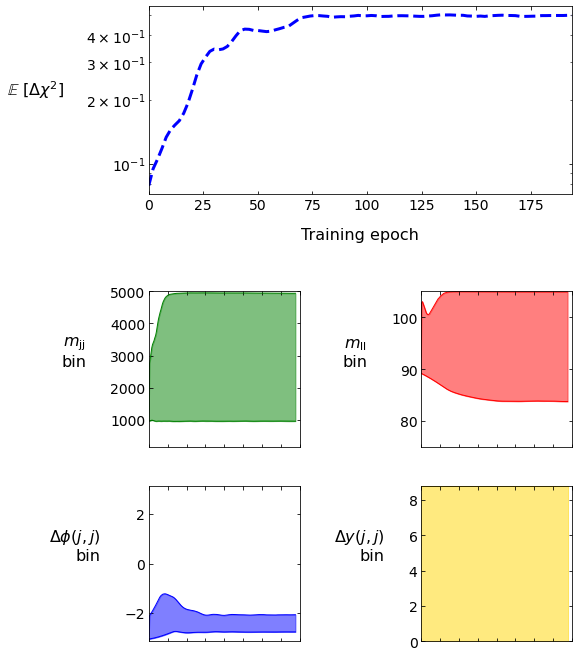

Plotting run index 77


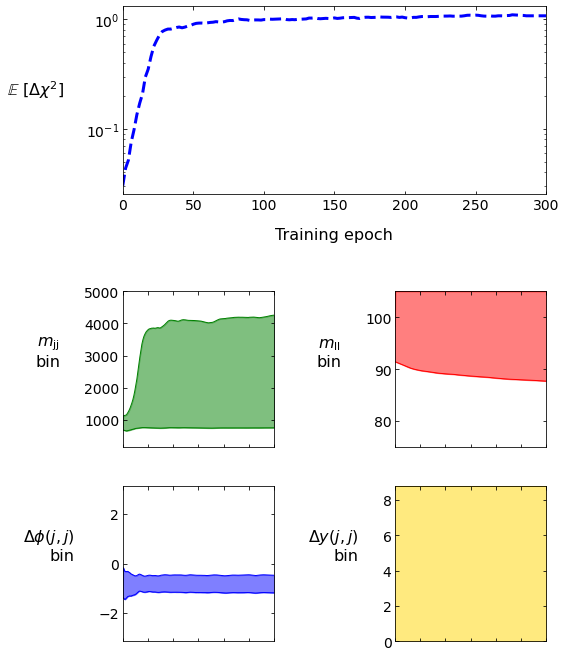

Plotting run index 84


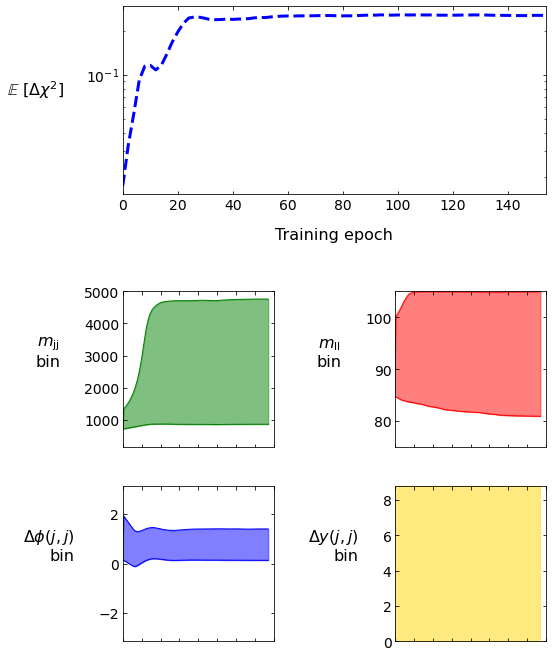

Plotting run index 4


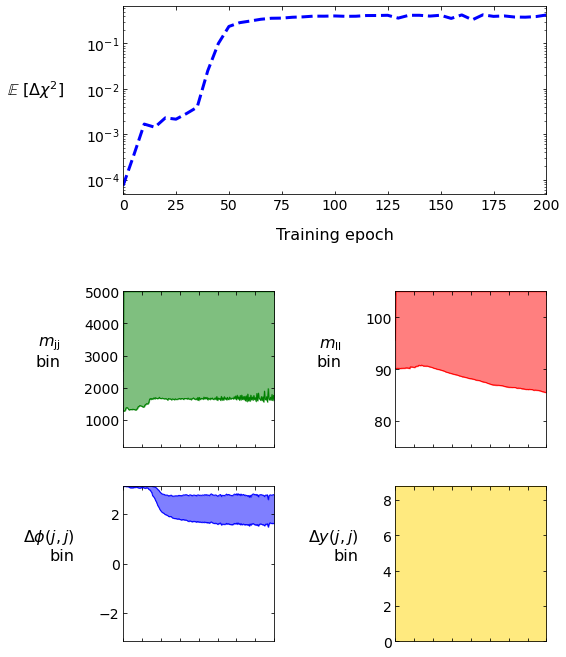

In [304]:

plot_run_indices = [80, 77, 84, 4]

for run_idx in plot_run_indices :
    
    print(f"Plotting run index {run_idx}")
    
    [params, train_loss, train_bins] = all_runs[run_idx]

    fig = plt.figure(figsize=(6, 9))
    ax  = fig.add_axes([0.01, 0.7, 0.98, 0.29])
    
    training_epochs = [t[0] for t in train_loss]
    ax.plot(training_epochs, [t[1] for t in train_loss], "--", c="blue", linewidth=3)
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=14)
    ax.set_yscale("log")
    ax.set_xlabel("Training epoch", fontsize=16, labelpad=15)
    ax.set_ylabel("$\mathbb{E}~[\Delta\chi^2]$", fontsize=16, labelpad=50, rotation=0)
    ax.set_xlim([training_epochs[0], training_epochs[-1]])
    xticks = ax.get_xticks()
    
    def plot_obs (ax, obs_idx, colour, alpha) :
        obs       = observables_order [obs_idx]
        obs_label = observables_labels[obs]
        obs_limit = observable_limits [obs]
        training_epochs, bins_lo, bins_hi = [v[0] for v in train_bins], [v[1][obs_idx] for v in train_bins], [v[2][obs_idx] for v in train_bins]
        ax.fill_between(training_epochs, bins_lo, bins_hi, color=colour, alpha=alpha)
        ax.plot(training_epochs, bins_lo, "-", linewidth=1, color=colour)
        ax.plot(training_epochs, bins_hi, "-", linewidth=1, color=colour)
        ax.set_xlim([training_epochs[0], training_epochs[-1]])
        ax.set_ylim([obs_limit[0], obs_limit[-1]])
        ax.set_xticks(xticks)
        ax.set_ylabel(obs_label + "\nbin", fontsize=16, labelpad=24, rotation=0, ha="right")
        ax.xaxis.set_ticklabels([])
        ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=14)
    
    ax  = fig.add_axes([0.01, 0.31, 0.35, 0.24])
    plot_obs(ax, 0, "green", 0.5)
    
    ax  = fig.add_axes([0.64, 0.31, 0.35, 0.24])
    plot_obs(ax, 1, "red", 0.5)
    
    ax  = fig.add_axes([0.01, 0.01, 0.35, 0.24])
    plot_obs(ax, 2, "blue", 0.5)
    
    ax  = fig.add_axes([0.64, 0.01, 0.35, 0.24])
    plot_obs(ax, 3, "gold", 0.5)
    
    plt.show()


In [ ]:
'''x_axis, y_axis = np.linspace(-6, 5, 49), np.linspace(0.1, 5.1, 26)
X, Y = np.meshgrid(x_axis, y_axis, indexing="ij")

Z = np.zeros(shape=X.shape)
for i,x in enumerate(x_axis) :
    print(x)
    for j,y in enumerate(y_axis) :
        Z[i, j] = np.exp(-loss_func([x, np.log(y)]))
Z = np.ma.masked_array(Z, mask=np.isnan(Z))

fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(1, 1, 1)
cbar = ax.contourf(X, Y, Z, levels=20)
plt.colorbar(cbar, label=r"$\langle q_{bin}\rangle$")
ax.set_ylabel("width", fontsize=15, labelpad=25)
ax.set_xlabel("low"  , fontsize=15, labelpad=25)

plt.show()'''

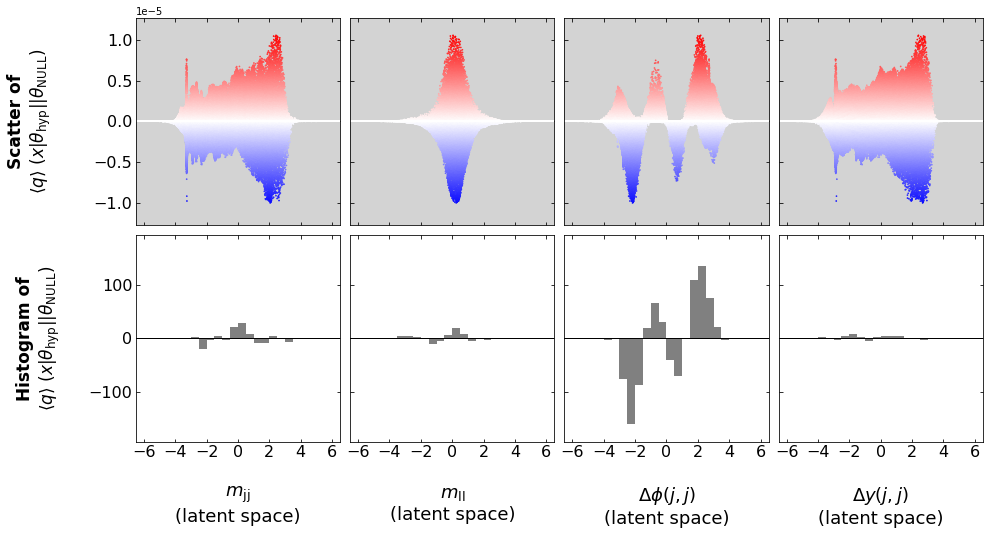

In [138]:
#  Study 1D projections of importance
#

bins=np.linspace(-6.5, 6.5, 27)
    
z_imp     = -2 * L_NULL * (logL_alt - logL_NULL)
z_imp_max = np.max(np.fabs(z_imp))
z_DLL     = -2 * (logL_alt - logL_NULL)
hist_max  = 0
for row_idx in range(num_observables) :
    hist_vals, _ = np.histogram(fake_white_datapoints[:,row_idx], weights=fake_datapoint_weights*z_DLL, bins=bins)
    hist_max     = np.max([hist_max, np.max(np.fabs(hist_vals))])
    
fig = plt.figure(figsize=(3*num_observables, 6))
for row_idx in range(num_observables) :
    x  = fake_white_datapoints[:,row_idx]
    
    ax = fig.add_subplot(2, num_observables, row_idx + 1)
    ax.scatter(x, z_imp, s=0.5, c=z_imp, cmap="bwr", vmin=-z_imp_max, vmax=z_imp_max)
    ax.set_facecolor("lightgrey")
    ax.axhline(0, c="white", linewidth=2)
    if row_idx == 0 :
        ax.set_ylabel("Scatter of\n" + r"${\langle q\rangle}~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=17, labelpad=41, weight="bold")
    else :
        ax.get_yaxis().set_ticklabels([])
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=16)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim(-1.2*z_imp_max, 1.2*z_imp_max)
    ax.get_xaxis().set_ticks(np.linspace(-6, 6, 7))
    ax.get_xaxis().set_ticklabels([])
    ax.text(0.95, 1.05, "", ha="right", va="bottom")
    
    x = fake_white_datapoints[:,row_idx]
    ax = fig.add_subplot(2, num_observables, num_observables + row_idx + 1)
    ax.hist(x, weights=fake_datapoint_weights*z_DLL, bins=bins, color="grey")
    ax.axhline(0, c="black", linewidth=1)
    if row_idx == 0 : 
        ax.set_ylabel("Histogram of\n" + r"${\langle q\rangle}~(x|\theta_{\rm hyp}||\theta_{\rm NULL})$", fontsize=17, labelpad=27, weight="bold")
    else :
        ax.get_yaxis().set_ticklabels([])
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=16)
    ax.set_xlabel(observables_labels[observables_order[row_idx]] +"\n(latent space)", fontsize=18, labelpad=25)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim(-1.2*hist_max, 1.2*hist_max)
    ax.get_xaxis().set_ticks(np.linspace(-6, 6, 7))
    
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.05, hspace=0.05)
plt.show()
    

In [77]:

input_fname_QCD = "../Data/SM_QCD_2M_rivet_output.pickle"
input_fname_EWK = "../Data/SM_EWK_1M_rivet_output.pickle"
input_fname_sig = "../Data/cWtil_0p1_full_400k_rivet_output.pickle"


In [78]:
#  Load and format the data
#

print(f"Creating QCD data table")
print(f" -- events from file {input_fname_QCD}")
data_table_QCD = DataTable(input_fname_QCD)
print(f" -- Table created with {data_table_QCD.get_num_events()} events")
for observable, limits in observable_limits.items() :
    print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
    data_table_QCD.filter(observable, limits[0], limits[1])
    print(f" -- {data_table_QCD.get_num_events()} events survived")
for observable in remove_observables :
    print(f" -- removing observable {observable}")
    data_table_QCD.remove_column(observable)
print(" -- ordering observables")
data_table_QCD.reorder(*observables_order)
data_table_QCD.print_summary()

print(f"Creating EWK data table")
print(f" -- events from file {input_fname_EWK}")
data_table_EWK = DataTable(input_fname_EWK)
print(f" -- Table created with {data_table_EWK.get_num_events()} events")
for observable, limits in observable_limits.items() :
    print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
    data_table_EWK.filter(observable, limits[0], limits[1])
    print(f" -- {data_table_EWK.get_num_events()} events survived")
for observable in remove_observables :
    print(f" -- removing observable {observable}")
    data_table_EWK.remove_column(observable)
print(" -- ordering observables")
data_table_EWK.reorder(*observables_order)
data_table_EWK.print_summary()

print(f"Creating sig data table")
print(f" -- events from file {input_fname_sig}")
data_table_sig = DataTable(input_fname_sig)
print(f" -- Table created with {data_table_sig.get_num_events()} events")
for observable, limits in observable_limits.items() :
    print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
    data_table_sig.filter(observable, limits[0], limits[1])
    print(f" -- {data_table_sig.get_num_events()} events survived")
for observable in remove_observables :
    print(f" -- removing observable {observable}")
    data_table_sig.remove_column(observable)
print(" -- ordering observables")
data_table_sig.reorder(*observables_order)
data_table_sig.print_summary()


Creating QCD data table
 -- events from file ../Data/SM_QCD_2M_rivet_output.pickle
 -- Table created with 2000000 events
 -- filtering observable m_ll between 75 and 105
 -- 1269318 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 1269300 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 1269300 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 1241601 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 1206816 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 1206816 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 1206816 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 1206816 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 1206749 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 1206181 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 1206181 event

In [79]:

data_QCD, weights_QCD = data_table_QCD.get_observables_and_weights()
weights_QCD           = weights_QCD * data_table_QCD.xsec_per_event * L
white_data_QCD, _     = whiten_axes (data_QCD, data_table_QCD.types, whitening_funcs=whitening_funcs)

data_EWK, weights_EWK = data_table_EWK.get_observables_and_weights()
weights_EWK           = weights_EWK * data_table_EWK.xsec_per_event * L
white_data_EWK, _     = whiten_axes (data_EWK, data_table_EWK.types, whitening_funcs=whitening_funcs)

data_sig, weights_sig = data_table_sig.get_observables_and_weights()
weights_sig           = weights_sig * data_table_sig.xsec_per_event * L
white_data_sig, _     = whiten_axes (data_sig, data_table_sig.types, whitening_funcs=whitening_funcs)


In [80]:

def get_n1_n2_real (bin_edges_lo, bin_widths) :
    if type(bin_edges_lo) == list : bin_edges_lo = np.array(bin_edges_lo)
    if type(bin_widths  ) == list : bin_widths   = np.array(bin_widths  )
    bin_edges_hi = bin_edges_lo + bin_widths
    ds1, ws1 = np.concatenate([white_data_QCD, white_data_EWK]), np.concatenate([weights_QCD, weights_EWK])
    ds2, ws2 = np.concatenate([white_data_QCD, white_data_sig]), np.concatenate([weights_QCD, weights_sig])
    n_1, n_2 = 0., 0.
    for x1, w1 in zip(ds1, ws1) :
        is_fid = True
        for obs_idx in range(num_observables) :
            if (x1[obs_idx] < bin_edges_lo[obs_idx]) : is_fid = False
            if (x1[obs_idx] > bin_edges_hi[obs_idx]) : is_fid = False
        if not is_fid : continue
        n_1 = n_1 + w1
    for x2, w2 in zip(ds2, ws2) :
        is_fid = True
        for obs_idx in range(num_observables) :
            if (x2[obs_idx] < bin_edges_lo[obs_idx]) : is_fid = False
            if (x2[obs_idx] > bin_edges_hi[obs_idx]) : is_fid = False
        if not is_fid : continue
        n_2 = n_2 + w2
    return n_1, n_2

bin_edges     [1000.000, 4000.000]  [0.000, 200.000]  [-3.142, -2.827]  [2.000, 9.000]
q, n1, n2 =    0.152      12767.23, 12723.22       (MC events)
q, n1, n2 =    0.001      17461.64, 17465.91       (method)

bin_edges     [1000.000, 4000.000]  [0.000, 200.000]  [-2.827, -2.513]  [2.000, 9.000]
q, n1, n2 =    0.063      6374.35, 6394.44       (MC events)
q, n1, n2 =    0.133      2937.02, 2956.82       (method)

bin_edges     [1000.000, 4000.000]  [0.000, 200.000]  [-2.513, -2.199]  [2.000, 9.000]
q, n1, n2 =    0.362      3409.20, 3444.52       (MC events)
q, n1, n2 =    0.186      2244.52, 2265.07       (method)

bin_edges     [1000.000, 4000.000]  [0.000, 200.000]  [-2.199, -1.885]  [2.000, 9.000]
q, n1, n2 =    0.073      2170.96, 2183.57       (MC events)
q, n1, n2 =    0.056      2626.30, 2638.42       (method)

bin_edges     [1000.000, 4000.000]  [0.000, 200.000]  [-1.885, -1.571]  [2.000, 9.000]
q, n1, n2 =    0.172      1437.33, 1453.15       (MC events)
q, n1, n2 =    0.012

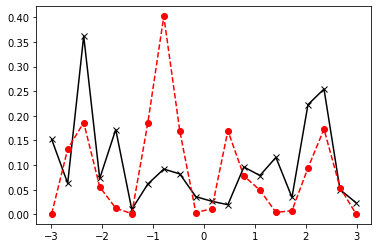

In [139]:

bin_edges = np.linspace(-np.pi, np.pi, 21)

dchi2_real, dchi2_est = [], []

for bin_lo, bin_hi in zip(bin_edges[:-1], bin_edges[1:]) :
    bin_edges_lo = np.array([1000., 0.  , bin_lo, 2.])
    bin_edges_hi = np.array([4000., 200., bin_hi, 9.])
    print("bin_edges     " + "  ".join([f"[{v1:.3f}, {v2:.3f}]" for v1, v2 in zip(bin_edges_lo, bin_edges_hi)]))
    bin_edges_lo = whiten_axes(np.array([bin_edges_lo]), data_table_QCD.types, whitening_funcs=whitening_funcs)[0][0]
    bin_edges_hi = whiten_axes(np.array([bin_edges_hi]), data_table_QCD.types, whitening_funcs=whitening_funcs)[0][0]
    #print("bin_edges", [f"[{v1:.3f}, {v2:.3f}]" for v1, v2 in zip(bin_edges_lo, bin_edges_hi)])
    bin_widths   = bin_edges_hi - bin_edges_lo
    
    n1_real, n2_real = get_n1_n2_real (bin_edges_lo, bin_widths)
    q_real           = get_q (n1_real, n2_real) if (n1_real>0) and (n2_real>0) else 0.
    
    n1_est , n2_est  = get_n1_n2 (bin_edges_lo, bin_widths)
    q_est            = get_q (n1_est , n2_est ) if (n1_est >0) and (n2_est >0) else 0.

    print(f"q, n1, n2 =    {q_real:.3f}      {n1_real:.2f}, {n2_real:.2f}       (MC events)")
    print(f"q, n1, n2 =    {q_est :.3f}      {n1_est :.2f}, {n2_est :.2f}       (method)")
    print()
    
    dchi2_real.append(q_real)
    dchi2_est .append(q_est )

print(f"dchi2_real = {np.sum(dchi2_real)}")
print(f"dchi2_est  = {np.sum(dchi2_est)}")

plt.plot(0.5*(bin_edges[:-1]+bin_edges[1:]), dchi2_real, "x-" , c="k")
plt.plot(0.5*(bin_edges[:-1]+bin_edges[1:]), dchi2_est , "o--", c="r")
plt.show()
